## Analysis
### Business Questions Answered
1. Do the amount of traffic accidents vary over a given year? Do they show seasonality? 
2. Does that also correlate with road conditions? What times of year are better/worse? 
3. What geographical areas do 311 Service Calls occur in? 
4. Do these translate to a similar number of traffic accidents? 

In [65]:
# Setup Spark Session & Begin using for Analysis
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, TimestampType
from pyspark.sql.functions import col

spark = SparkSession \
    .builder \
    .appName('01_analysis_nb') \
    .getOrCreate()

service_dta = spark.read.parquet('data/takehome-process/2021-09-17/service_data.parquet')
traffic_dta = spark.read.parquet('data/takehome-process/2021-09-17/traffic_accidents.parquet')

In [66]:
# Convert the First Occurence to a Proper Timestamp class
traffic_dta.withColumn("first_occurrence_date", col("first_occurrence_date").cast(TimestampType()))

DataFrame[objectid_1: string, incident_id: string, offense_id: string, offense_code: string, offense_code_extension: string, top_traffic_accident_offense: string, first_occurrence_date: timestamp, last_occurrence_date: string, reported_date: string, incident_address: string, geo_x: string, geo_y: string, geo_lon: string, geo_lat: string, district_id: string, precinct_id: string, neighborhood_id: string, bicycle_ind: string, pedestrian_ind: string, harmful_event_seq_1: string, harmful_event_seq_2: string, harmful_event_seq_3: string, road_location: string, road_description: string, road_contour: string, road_condition: string, light_condition: string, tu1_vehicle_type: string, tu1_travel_direction: string, tu1_vehicle_movement: string, tu1_driver_action: string, tu1_driver_humancontribfactor: string, tu1_pedestrian_action: string, tu2_vehicle_type: string, tu2_travel_direction: string, tu2_vehicle_movement: string, tu2_driver_action: string, tu2_driver_humancontribfactor: string, tu2_pe

In [177]:
# Time Series of Traffic Accidents
traffic_dta.createOrReplaceTempView('tmp_traffic')
sql_query = "SELECT date_format(first_occurrence_date, 'yyyy-MM-dd') as day, count(*) as count " \
            "FROM tmp_traffic " \
            "GROUP BY day"
            
df_timeseries = spark.sql(sql_query)


#### Do the amount of traffic accidents vary over a given year? Do they show seasonality? 

<AxesSubplot:title={'center':'Across Years'}, xlabel='day'>

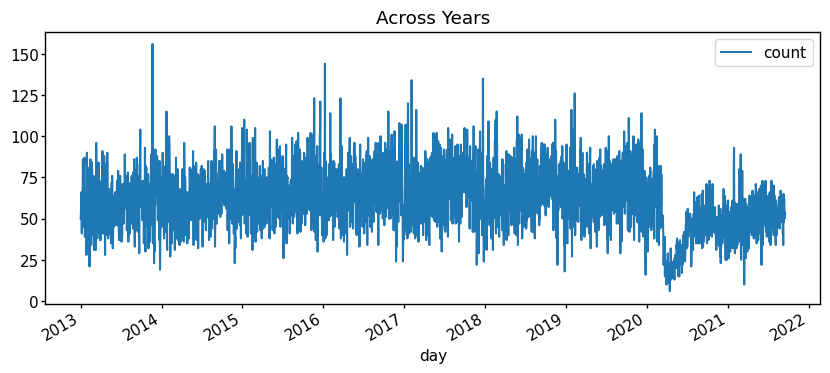

In [110]:
# Dataset is small - convert to pandas for easy plot. 
df_timeseries_plot = df_timeseries.toPandas()
df_timeseries_plot['day'] = pd.to_datetime(df_timeseries_plot.day)
# Across the entire span of the dataset
df_timeseries_plot.plot(x='day', y='count', figsize=(10, 4), title='Across Years')

A few thoughts about traffic data: 
    1. COVID has an effect on the amount of accidents beginning mid-2020. That corresponds with the first shut down order in the Denver Metro Area. Even since lifting the harshest restrictions, it appears that the accidents are down compared to historical information. 
    2. There is indeed seasonality in the amount of traffic accidents. However, this graph hides this effect. The next plot below focuses on the months of year to get into more detail about the data. 

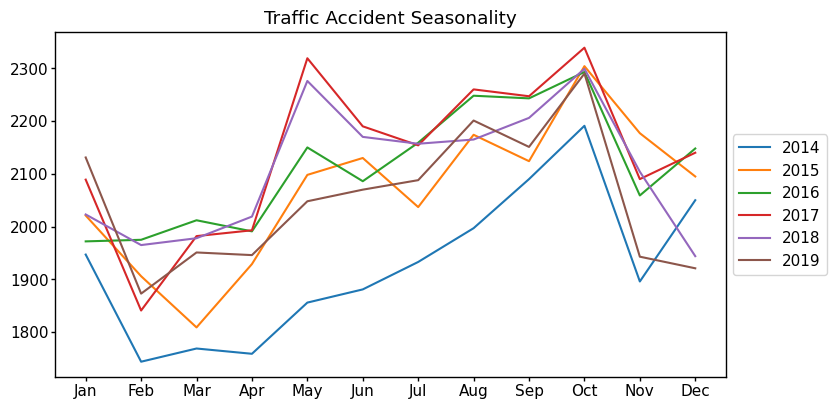

In [141]:
# Only complete years before COVID
# Could also be done using Pyspark if Needed.
df_timeseries_plot = df_timeseries_plot.loc[(df_timeseries_plot.day >= '2014-01-01') & (df_timeseries_plot.day < '2020-01-01'), :]

# Grab Plotting Packages
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

# Convert Data into an Array of Years
df_timeseries_plot['year'] = df_timeseries_plot['day'].dt.year
df_timeseries_plot['mth'] = df_timeseries_plot['day'].dt.month
df_timeseries_plot_season = pd.pivot_table(
    df_timeseries_plot, index='mth', columns='year', aggfunc='sum')
df_timeseries_plot_season.columns=df_timeseries_plot_season.columns.droplevel()
df_timeseries_plot_season.head()

# Plot
plt.rcParams["figure.figsize"] = (10,4)
ax = plt.figure().add_subplot(111)
ax.plot(df_timeseries_plot_season)

# Getting readable tick marks
ticklabels = [datetime.date(1900, item, 1).strftime('%b') for item in df_timeseries_plot_season.index.unique()]
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(ticklabels)

# Years as Legend
ax.legend(df_timeseries_plot_season.columns.tolist(), loc='center left', bbox_to_anchor=(1, .5)) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.title('Traffic Accident Seasonality')
plt.show()

As was alluded to before, there is indeed seasonality with traffic accident data. Generally, the highest number of accidents occur in the 2nd and 3rd quarter of that year. Initially, I assumed that it would be cold weather & snow that caused the rise in accidents. However, that is not necessarily the case as we can see here. The highest cases generally occur in the September and October. We can use Linear Regression to express this more clearly. 

In [175]:
from statsmodels.formula.api import ols
df_ols = df_timeseries_plot.groupby(['mth', 'year'], as_index=False)['count'].sum()
df_ols['mth'] = df_ols['mth'].apply(lambda x: datetime.date(1900, x, 1).strftime('%b'))
df_ols.head()
mdl = ols('count ~ C(mth)', data=df_ols)
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     8.440
Date:                Sat, 18 Sep 2021   Prob (F-statistic):           9.61e-09
Time:                        15:03:26   Log-Likelihood:                -426.08
No. Observations:                  72   AIC:                             876.2
Df Residuals:                      60   BIC:                             903.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1939.5000     40.209     48.235      0.000    1859.069    2019.931
C(mth)[T.Aug]   234.6667     56.865      4.127      0.000     120.921     348.413
C(mth)[T.Dec]   110.1667     56.865      1.937      0.057      -3.579     223.913
C(mth)[T.Feb]   -55.5000     56.865     -0.976      0.333    -169.246      58.246
C(mth)[T.Jan]    91.0000     56.865      1.600      0.115     -22.746     204.746
C(mth)[T.Jul]   148.5000     56.865      2.611      0.011      34.754     262.246
C(mth)[T.Jun]   148.3333     56.865      2.609      0.011      34.587     262.079
C(mth)[T.Mar]   -22.6667     56.865     -0.399      0.692    -136.413      91.079
C(mth)[T.May]   185.0000     56.865      3.253      0.002      71.254     298.746
C(mth)[T.Nov]   105.3333     56.865      1.852      0.069      -8.413     219.079
C(mth)[T.Oct]   346.5000     56.865      6.093      0.000     232.754     460.246
C(mth)[T.Sep]   237.3333     56.865      4.174      0.000     123.587     351.079
==============================================================================
Omnibus:                        6.551   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.102
Skew:                          -0.705   Prob(JB):                       0.0473
Kurtosis:                       3.209   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here you can see the output where April is the reference intercept. Indeed, on average, it appears the month of October and September are the highest in terms of traffic accidents followed by August. It seems that Fall in Denver is the worst time to be driving. 

#### Does that also correlate with road condition?

In [241]:
# Include Road Conditions & Pivot to Columns. Neat feature of Spark SQL.
sql_query = """
SELECT * FROM (
    SELECT year(first_occurrence_date) as year, month(first_occurrence_date) as mth, road_condition, COUNT(*) as count
    FROM tmp_traffic
    WHERE road_condition IS NOT NULL AND road_condition <> ' '
    GROUP BY year, mth, road_condition
)
PIVOT (
  SUM(count)
  FOR year in (
    2014, 2015, 2016, 2017, 2018, 2019
  )
)

"""
            
df_cond = spark.sql(sql_query) 

In [250]:
df_cond_pd = df_cond.toPandas()

# Percentage of Columns in a given year
df_cond_pd = df_cond_pd.fillna(0)
df_cond_pd_rc = df_cond_pd.drop(columns='mth')
df_cond_pd_rc = df_cond_pd_rc.groupby('road_condition', as_index=False).sum()

# Helper Fcn
def percentage_col(df: pd.DataFrame) -> pd.DataFrame:
    """Converts Columns to %"""
    return (100. * df / df.sum()).round(1).astype(str) + '%' 

df_cond_pd_rc.iloc[:, 1:] = percentage_col(df_cond_pd_rc.iloc[:, 1:])

# Do road conditions matter? 
df_cond_pd_rc.head(20)


,road_condition,2014,2015,2016,2017,2018,2019
0,,1.7%,1.4%,1.4%,2.3%,1.7%,7.4%
1,DRY,82.0%,80.8%,87.2%,87.0%,88.5%,77.2%
2,DRY WITH VISIBLE ICY ROAD TREATMENT,0.1%,0.1%,0.1%,0.1%,0.1%,0.1%
3,FOREIGN MATERIAL,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
4,ICY,4.4%,4.2%,2.3%,2.0%,2.0%,4.0%
5,ICY WITH VISIBLE ICY ROAD TREATMENT,0.1%,0.1%,0.0%,0.0%,0.0%,0.1%
6,MUDDY,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
7,SLUSHY,0.6%,1.0%,0.6%,0.3%,0.2%,0.9%
8,SLUSHY WITH VISIBLE ICY ROAD TREATMENT,0.1%,0.1%,0.1%,0.0%,0.0%,0.1%
9,SNOWY,3.1%,2.8%,2.3%,1.4%,1.4%,3.1%


As it turns out, most accidents occur in Dry conditions. Only a small fraction (~ 10%) occur in Icy or Wet conditions. Is that also true for our most accident prone months, September & October? 

In [261]:
# September & October
df_cond_pd = df_cond.toPandas()
df_cond_pd = df_cond_pd.fillna(0)
df_cond_fall = df_cond_pd.loc[df_cond_pd.mth.isin([9, 10]), :].drop(columns='mth')
df_cond_fall = df_cond_fall.groupby('road_condition', as_index=False).sum()

# %'s
df_cond_fall.iloc[:, 1:] = percentage_col(df_cond_fall.iloc[:, 1:])

# Fall
df_cond_fall.head(20)

,road_condition,2014,2015,2016,2017,2018,2019
0,,1.6%,1.5%,1.8%,1.0%,1.2%,7.4%
1,DRY,91.5%,92.1%,96.6%,90.2%,90.5%,82.4%
2,DRY WITH VISIBLE ICY ROAD TREATMENT,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
3,FOREIGN MATERIAL,0.0%,0.0%,0.0%,0.0%,0.1%,0.0%
4,ICY,0.0%,0.0%,0.0%,0.1%,0.1%,2.1%
5,ICY WITH VISIBLE ICY ROAD TREATMENT,0.0%,0.0%,0.0%,0.0%,0.0%,0.1%
6,MUDDY,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
7,SLUSHY,0.0%,0.0%,0.0%,0.0%,0.0%,0.6%
8,SLUSHY WITH VISIBLE ICY ROAD TREATMENT,0.0%,0.0%,0.0%,0.0%,0.0%,0.1%
9,SNOWY,0.0%,0.0%,0.0%,0.2%,0.4%,2.3%


Here we can see that the majority of accidents are occuring during Dry conditions. In fact, conditions are generally drier than on average during these months. Perhaps it is the pumpkin spice lattes? 

#### What geographical areas do 311 Service Calls occur in? 
Denver.Gov publishes shape files for plotting purposes. We will be grabbing that data and combining it with our Spark DataFrame information. 

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry
0,2,Auraria,None,None,"POLYGON ((-105.00042 39.74552, -105.00041 39.7..."
1,21,Cory - Merrill,None,None,"POLYGON ((-104.94070 39.69540, -104.94070 39.6..."


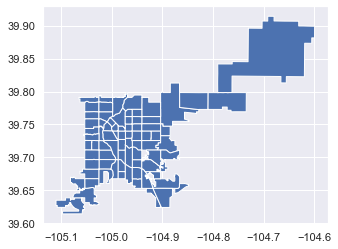

In [273]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
sns.set(style="darkgrid")
%matplotlib inline
nb = 'https://www.denvergov.org/media/gis/DataCatalog/statistical_neighborhoods/shape/statistical_neighborhoods.zip'
denver = gpd.read_file(nb)

# Show Basic plot
denver.plot(figsize=(8, 4))
denver.head(2)

In [276]:
# Pyspark Count of 311 Calls
service_dta.createOrReplaceTempView('tmp_service')
sql_query = """
    SELECT neighborhood, count(*) ct
    FROM tmp_service
    GROUP BY neighborhood

"""
            
df_nb = spark.sql(sql_query)
df_nb.show(2)

+--------------------+----+
|        neighborhood|  ct|
+--------------------+----+
|Gateway - Green V...|5209|
|       Hampden South|1967|
+--------------------+----+
only showing top 2 rows



6052.0


/var/folders/qn/1qr4w3zj7g9049dj_4f36gg40000gq/T/ipykernel_28140/345411276.py:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


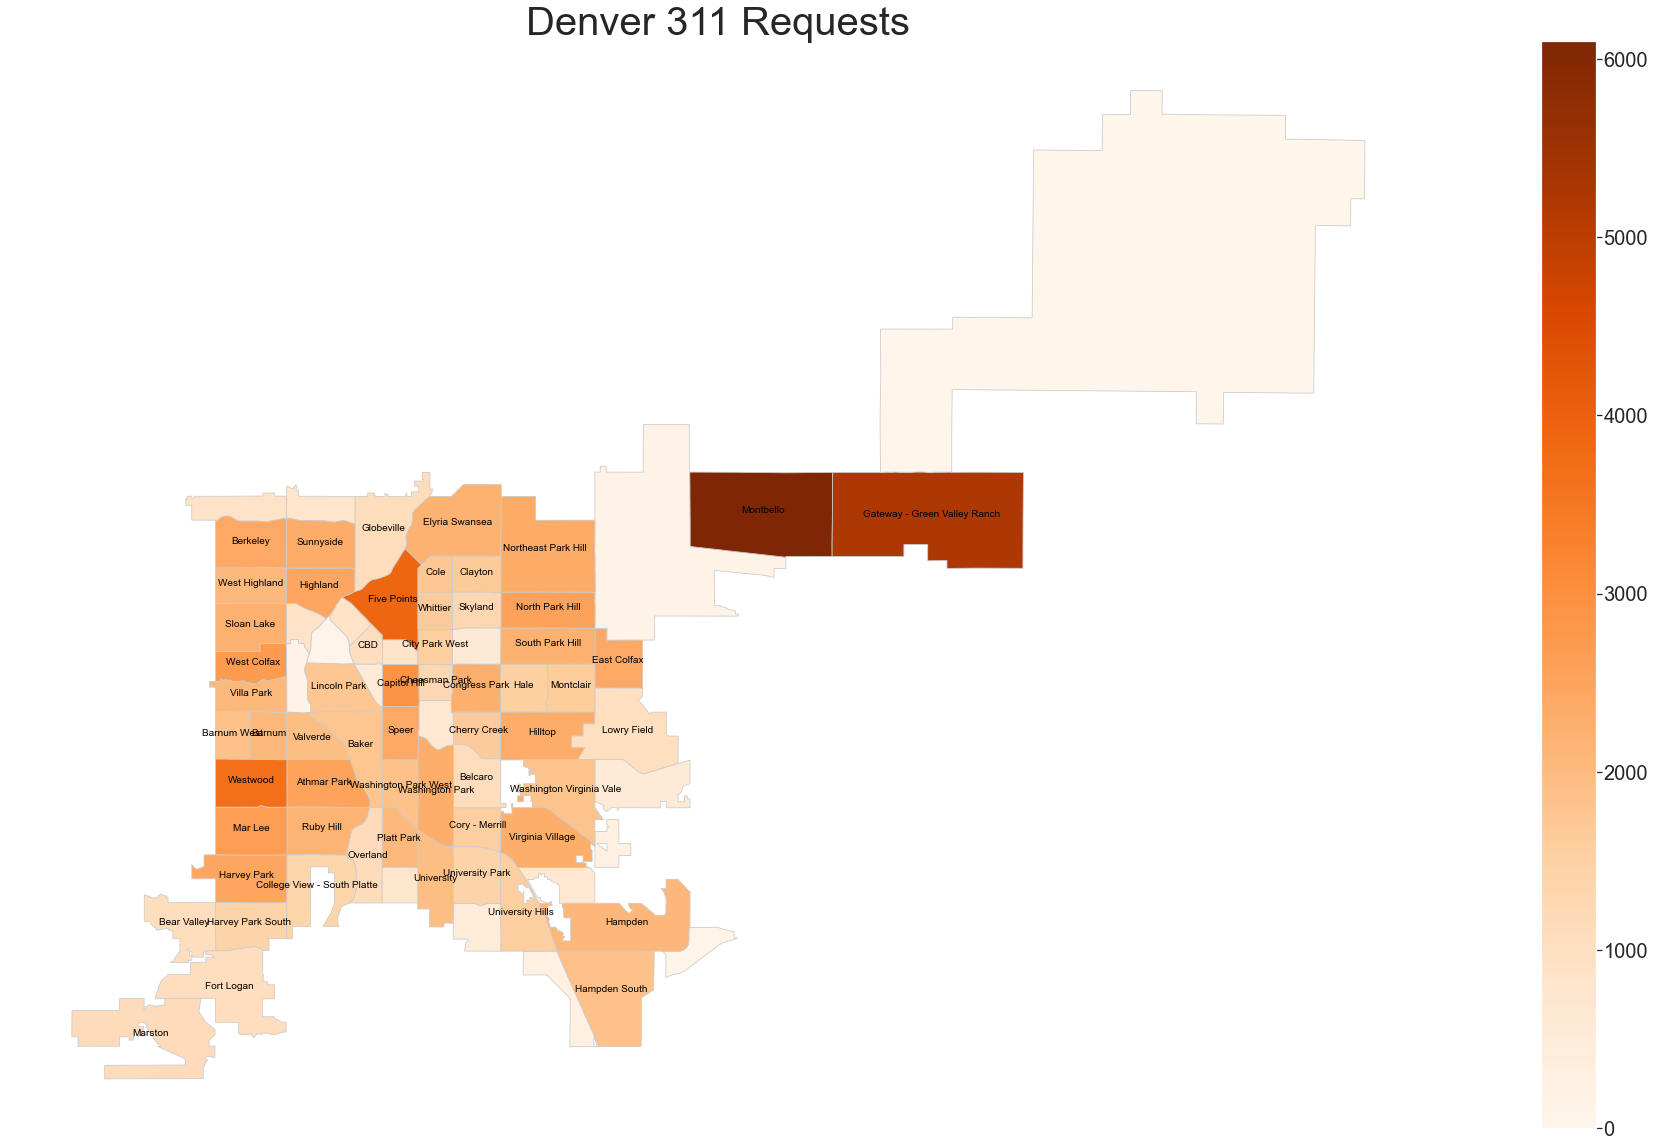

In [300]:
# Combine with our Shape File
heatmap_dta = pd.merge(denver, df_nb.toPandas(), left_on='NBHD_NAME', right_on='neighborhood', how='left')
heatmap_dta = heatmap_dta.fillna(300)
print(heatmap_dta.ct.max())

# Plot! 
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Denver 311 Requests', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 6100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
heatmap_dta.plot('ct', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(50,20))

# Annotate Large Request #s
for idx, row in heatmap_dta.iterrows():
    if(row['ct'] > 1000):
        plt.annotate(s=row['NBHD_NAME'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize='medium', color='black', wrap=True)
plt.show()

Here you can see each neighborhood in Denver colored by the amount of 311 requests they receive. Very quickly you can spot areas with higher than normal requests. 5 Points, Westwood, Montbello, and Green Valley Ranch seems to have a high number of requests. Do these areas also translate to increased traffic accidents? 

In [310]:
sql_query = """
SELECT * FROM (
    SELECT neighborhood_id, year(first_occurrence_date) as year, COUNT(*) as count
    FROM tmp_traffic
    
    GROUP BY neighborhood_id, year
)
"""      
df_nbs = spark.sql(sql_query) 

In [317]:
# Again, we will rank them using percentages - Top 10. 
df_nbs2 = df_nbs.toPandas()
df_nbs2 = df_nbs2.groupby('neighborhood_id', as_index=False)['count'].mean()
df_nbs2.iloc[:, 1:] = percentage_col(df_nbs2.iloc[:, 1:])
df_nbs2 = df_nbs2.sort_values('count', ascending=False)
df_nbs2.head(10)

,neighborhood_id,count
10,Central Park,5.6%
2,Baker,4.9%
26,Five Points,3.4%
33,Hampden South,3.1%
41,Lincoln Park,3.0%
9,Capitol Hill,2.9%
45,Montbello,2.7%
29,Globeville,2.5%
36,Highland,2.4%
25,Elyria Swansea,2.2%


Although Five Points and Montbello are in the top 10, we do not see Westwood or Green Valley Ranch. Generally. it seems that northeast Denver is represented with the most traffic accidents as opposed to the more generally located 311 calls.